# Let's experiment with the ReLU activation

In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from ei import topology_of, EI_of_layer

In [2]:
# Pretty colormaps
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(1.0 * pos / size)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(1.0 * pos / size)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


**These ReLU EI measurements are going to depend on how the histogram function handles inputs which fall outside of the range. Let's experiment with this:**

In [9]:
from fast_histogram import histogram2d

In [20]:
x = np.array([-1, -0.6, -0.3, 0.1, 0.3, 0.7, 0.9, 2.0])
y = np.array([0, 0, 0, 0.1, 0.3, 0.7, 0.9, 2.0])

In [21]:
histogram2d(x, y, bins=5, range=((0, 1), (0, 1)))

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

**in the above example, all the (x, y) pairs are either in the range or outside the range. Only the ones inside are put into the histogram. Let's now see what happens when some (x, y) pairs have an x in the range and a y outside it**

In [35]:
x = np.array([-1, -0.6, -0.3, 0.05, 0.25, 0.7, 0.9, 2.0])
y = 2 * x
mask = y > 0
y = mask * y
print(x)
print(y)

[-1.   -0.6  -0.3   0.05  0.25  0.7   0.9   2.  ]
[-0.  -0.  -0.   0.1  0.5  1.4  1.8  4. ]


In [36]:
histogram2d(x, y, bins=5, range=((0, 1), (0, 1)))

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

**This is great! The histogram only includes pairs where both x and y are inside the range. This is the expected, ideal behavior. What it means for EI is that as the weight gets bigger, if the range doesn't get correspondingly bigger, many examples will not be included in the EI calculation.**

# First, I'm going to experiment with lots of different input and output ranges

## (0, 1) -> (0, 1) 

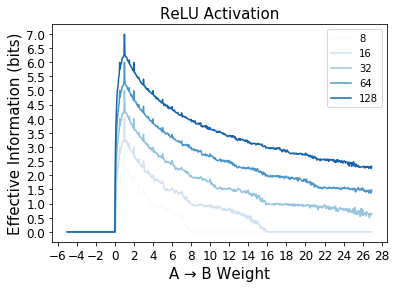

In [12]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(-5, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(0, 1), out_range=(0, 1), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend()

## (0, 1) -> (0, 5) 


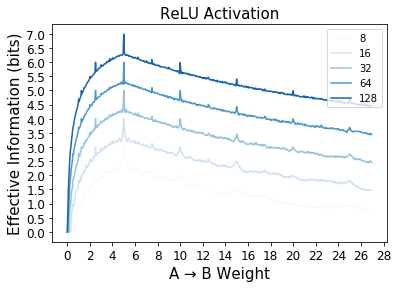

In [8]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(0, 1), out_range=(0, 5), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend()

## (0, 1) -> (0, 10) 

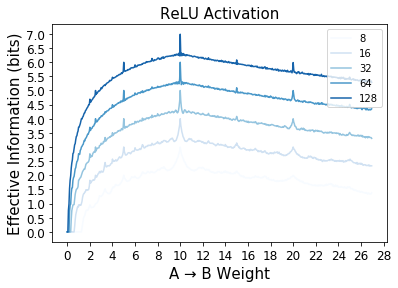

In [7]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 27, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(0, 1), out_range=(0, 10), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(loc="upper right")

## For this one, ensure that all outputs fall in the range: (0, 1) -> (0, 10)

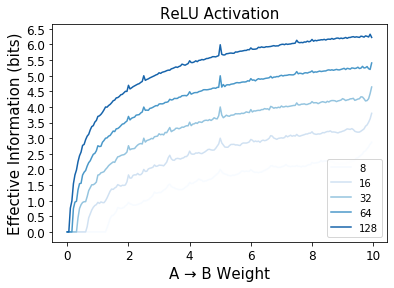

In [40]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 10, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(0, 1), out_range=(0, 10), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(loc="lower right")

## (-10, 10) -> (-10, 10)

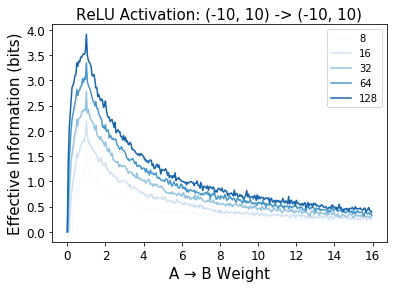

In [55]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 16, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(-10, 10), out_range=(-10, 10), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation: (-10, 10) -> (-10, 10)", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(loc="upper right")

plt.savefig("figures/relu/relu_-10_10_-10_10_1d_blue", dpi=300)

## (-10, 10) -> (-10, 100)

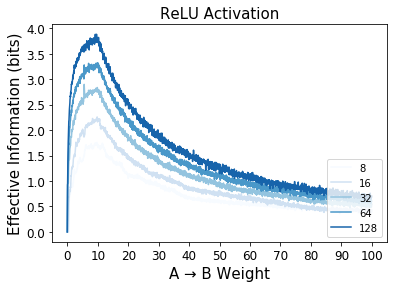

In [45]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 100, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(-10, 10), out_range=(-10, 100), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(loc="lower right")

## (0, 10) -> (0, 10)

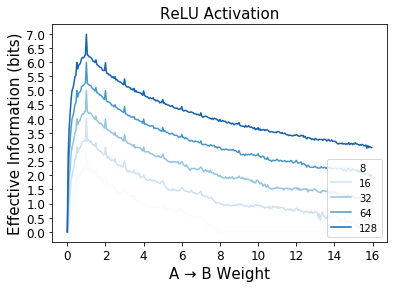

In [46]:
singleton = nn.Linear(1, 1, bias=False).to(device)
top = topology_of(singleton, torch.zeros((1, 1)).to(device))

fig, ax = plt.subplots(1,1)

ws = np.arange(0, 16, 0.05)
binSizes = [8, 16, 32, 64, 128]
for binSize in binSizes:
    color = blueMap(binSizes, binSize)
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=5000, batch_size=1000, bins=binSize, 
                               in_range=(0, 10), out_range=(0, 10), activation=nn.ReLU(), device=device))
#     if binSize == 64: color = 'black'   
    ax.plot(ws, eis, color=color, label=str(binSize))
    
# TODO: add a legend with the greyscale values
    
# Perhaps use tickmarks of e size?
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.0))
ax.tick_params(axis='both',which='major',labelsize=12)
#ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(numpy.e))
#ax.xaxis.set_ticklabels(['','0','e','2e','3e','4e','5e','6e','7e','8e','9e','10e'])

plt.draw()
limit = ax.get_ylim()
plt.autoscale(False)
# Plot the vertical line indicating e
# plt.plot((np.e, np.e), (limit[0], 5.6), 'gray')

# fitY = EIfit(plotValues)
# plt.plot(plotValues, fitY)

# The labels

ax.set_title("ReLU Activation", fontsize=15)
ax.set_xlabel('A → B Weight', fontsize=15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
plt.legend(loc="lower right")

## A, B -> C ReLU, Gray

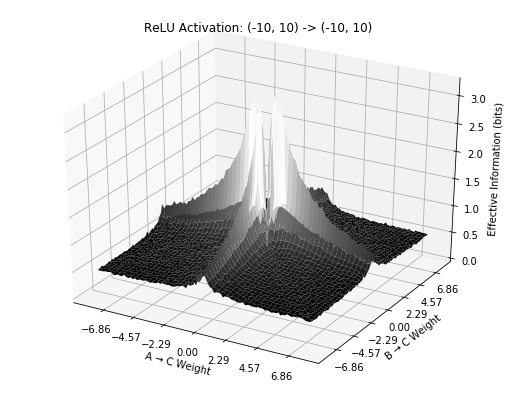

In [60]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -8.0, 8.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = EI_of_layer(tiny_network, top, samples=10000, batch_size=1000, bins=bins, 
                     in_range=(-10, 10), out_range=(-10, 10), activation=nn.ReLU(), device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.gray)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(size / 7))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(size / 7))

ax.set_title("ReLU Activation: (-10, 10) -> (-10, 10)")
ax.set_xlabel('A → C Weight')
ax.set_ylabel('B → C Weight')
ax.set_zlabel('Effective Information (bits)')

plt.savefig("figures/relu/relu_-10_10_-10_10_2d-gray", dpi=300)

## A, B -> C ReLU, Blue

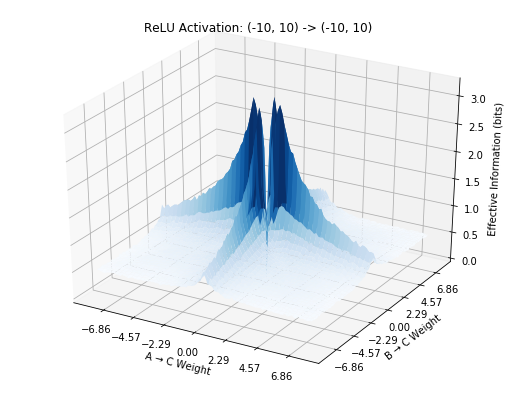

In [61]:
tiny_network = nn.Linear(2, 1, bias=False).to(device)
top = topology_of(tiny_network, input=torch.zeros(1, 2).to(device))

bins = 64
evalPoints = 100 # originally 50... total = evalPoints * evalPoints
lbound, ubound = -8.0, 8.0
stepSize = (ubound - lbound) / evalPoints

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')
x = y = np.arange(lbound, ubound, stepSize)
X, Y = np.meshgrid(x, y)
rX,rY = np.ravel(X), np.ravel(Y)

eis = []
for i in range(evalPoints * evalPoints):
    wA, wB = rX[i], rY[i]
    weights = torch.tensor([[wA, wB]]).to(device)
    tiny_network.weight.data = weights
    EI = EI_of_layer(tiny_network, top, samples=10000, batch_size=1000, bins=bins, 
                     in_range=(-10, 10), out_range=(-10, 10), activation=nn.ReLU(), device=device)
    eis.append(EI)
    
zs = np.array(eis)
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=plt.cm.Blues)

size = ubound - lbound
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(size / 7))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(size / 7))

ax.set_title("ReLU Activation: (-10, 10) -> (-10, 10)")
ax.set_xlabel('A → C Weight')
ax.set_ylabel('B → C Weight')
ax.set_zlabel('Effective Information (bits)')

plt.savefig("figures/relu/relu_-10_10_-10_10_2d-blue", dpi=300)